In [29]:
import xarray as xr
from evaluations.confusion_table import  compute_score, plot_confusion_table, compute_all_scores
import matplotlib.pyplot as plt
analysis_folder = '/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_3/analyses/confusion_table_test'
nasa_l3_metrics_ds = xr.open_dataset(f"{analysis_folder}/confusion_table_WY_2023_2024_SNPP_nasa_l3_res_375m.nc", decode_cf=True)
mf_metrics_ds = xr.open_dataset(f"{analysis_folder}/confusion_table_WY_2023_2024_SNPP_meteofrance_l3_res_375m.nc", decode_cf=True)
nasa_pseudo_l3_metrics_ds = xr.open_dataset(f"{analysis_folder}/confusion_table_WY_2023_2024_SNPP_nasa_pseudo_l3_res_375m.nc", decode_cf=True)

In [27]:
import numpy as np
np.arange(0, 370, 45)

array([  0,  45,  90, 135, 180, 225, 270, 315, 360])

In [36]:
mf_metrics_ds.slope_bins

<xarray.DataArray 'slope_bins' (slope_bins: 4)> Size: 32B
array([10, 30, 50, 90])
Coordinates:
  * slope_bins  (slope_bins) int64 32B 10 30 50 90
Attributes:
    AREA_OR_POINT:  Area

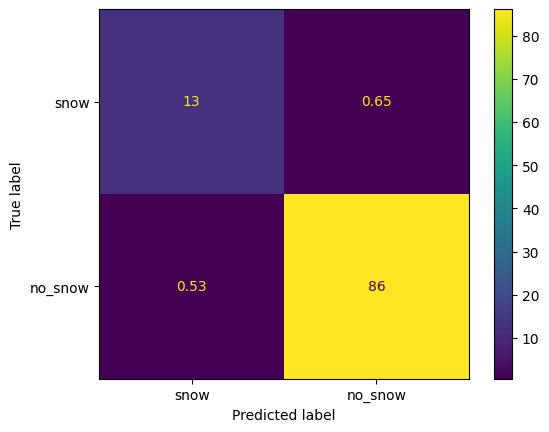

In [40]:
mf_metrics_ds = xr.open_dataset(f"{analysis_folder}/confusion_table_WY_2023_2024_SNPP_meteofrance_l3_res_375m.nc", decode_cf=True)
plot_confusion_table(mf_metrics_ds.sel(slope_bins=mf_metrics_ds.slope_bins[1])) 

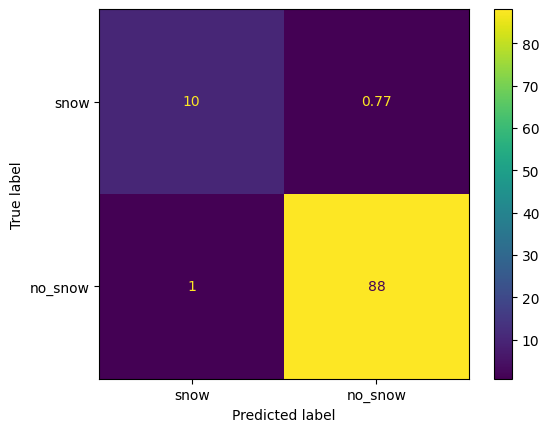

In [39]:
nasa_metrics_ds = xr.open_dataset(f"{analysis_folder}/confusion_table_WY_2023_2024_SNPP_nasa_l3_res_375m.nc", decode_cf=True)
plot_confusion_table(nasa_metrics_ds.sel(slope_bins=mf_metrics_ds.slope_bins[1])) 

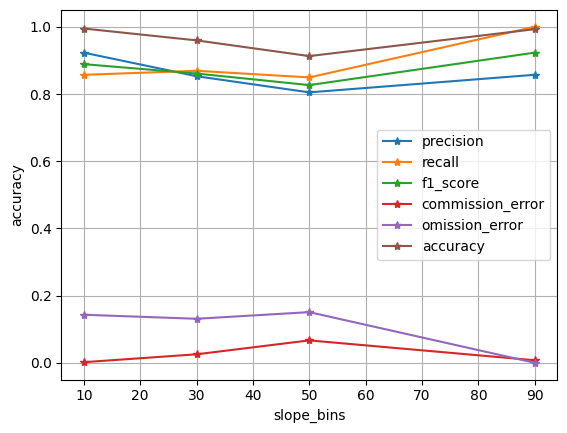

In [61]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
results = nasa_pseudo_l3_metrics_ds.sel(sensor_zenith_bins=slice(0,None)).groupby('slope_bins').map(compute_all_scores)
for dv in results:
    results[dv].plot.line('-*',ax=ax, label=dv)
ax.legend()
ax.grid()

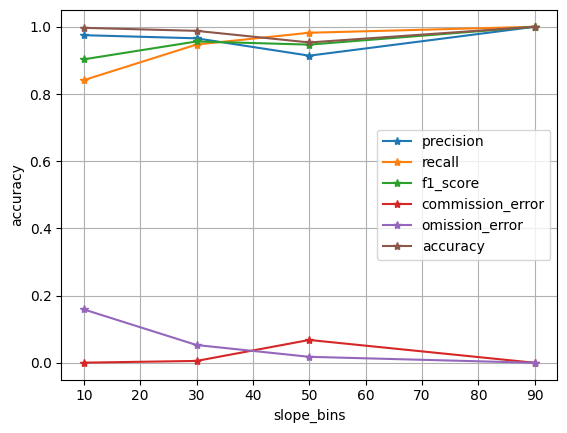

In [55]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
results = mf_metrics_ds.sel(sensor_zenith_bins=slice(45,None)).groupby('slope_bins').map(compute_all_scores)
for dv in results:
    results[dv].plot.line('-*',ax=ax, label=dv)
ax.legend()
ax.grid()

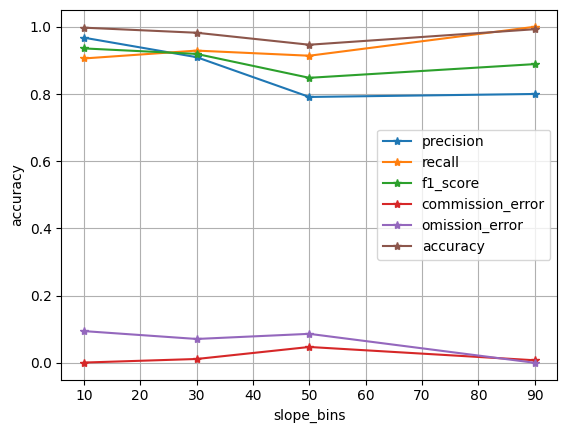

In [42]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
results = nasa_l3_metrics_ds.groupby('slope_bins').map(compute_all_scores)
for dv in results:
    results[dv].plot.line('-*',ax=ax, label=dv)
ax.legend()
ax.grid()

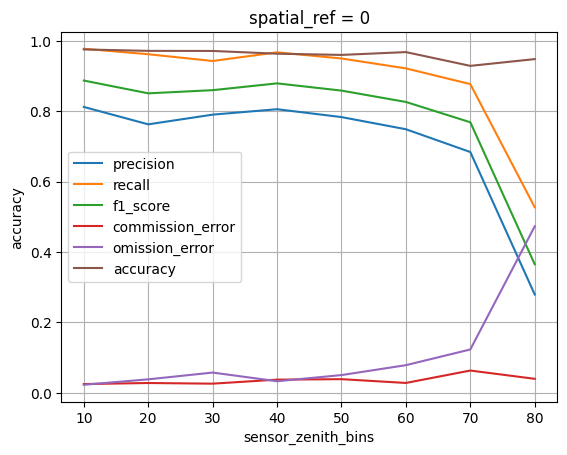

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
results = mf_metrics_ds.groupby('sensor_zenith_bins').map(compute_all_scores)
for dv in results:
    results[dv].plot.line(ax=ax, label=dv)
ax.legend()
ax.grid()

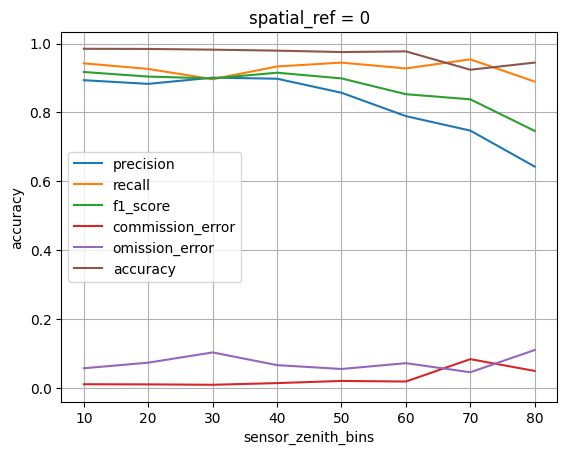

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
results = nasa_pseudo_l3_metrics_ds.groupby('sensor_zenith_bins').map(compute_all_scores)
for dv in results:
    results[dv].plot.line(ax=ax, label=dv)
ax.legend()
ax.grid()

In [ ]:
mf_metrics_ds.sel(forest_mask_bins=0).groupby('sensor_zenith_bins').map(accuracy)

<xarray.DataArray (sensor_zenith_bins: 9)> Size: 72B
array([0.98173406, 0.97584876, 0.97731227, 0.97847285, 0.96467257,
       0.97293504, 0.94169941, 0.98543834,        nan])
Coordinates:
    forest_mask_bins    float64 8B 0.0
    spatial_ref         int64 8B 0
  * sensor_zenith_bins  (sensor_zenith_bins) int64 72B 10 20 30 40 ... 70 80 255

In [7]:
nasa_pseudo_l3_metrics_ds.sel(forest_mask_bins=0).groupby('sensor_zenith_bins').map(compute_score, ['false_alarm_ratio'])

<xarray.DataArray (sensor_zenith_bins: 9)> Size: 72B
array([0.04418219, 0.0581323 , 0.05144611, 0.04774437, 0.08324594,
       0.13511207, 0.17991348, 0.30024814,        nan])
Coordinates:
    forest_mask_bins    float64 8B 0.0
    spatial_ref         int64 8B 0
  * sensor_zenith_bins  (sensor_zenith_bins) int64 72B 10 20 30 40 ... 70 80 255

In [5]:
mf_metrics_ds.sel(forest_mask_bins=0).groupby('sensor_zenith_bins').map(compute_score, ['false_alarm_ratio'])

<xarray.DataArray (sensor_zenith_bins: 9)> Size: 72B
array([0.076175  , 0.12102034, 0.07612176, 0.06139751, 0.11482717,
       0.11918732, 0.18352708, 0.5       ,        nan])
Coordinates:
    forest_mask_bins    float64 8B 0.0
    spatial_ref         int64 8B 0
  * sensor_zenith_bins  (sensor_zenith_bins) int64 72B 10 20 30 40 ... 70 80 255

In [2]:
print('period')
print(nasa_l3_metrics_ds.coords['time'])

period
<xarray.DataArray 'time' (time: 314)> Size: 3kB
array(['2023-10-01T00:00:00.000000000', '2023-10-02T00:00:00.000000000',
       '2023-10-03T00:00:00.000000000', ..., '2024-09-28T00:00:00.000000000',
       '2024-09-29T00:00:00.000000000', '2024-09-30T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int64 8B ...
  * time         (time) datetime64[ns] 3kB 2023-10-01 2023-10-02 ... 2024-09-30


NASA L3 
Overall accuracy: 0.9841477142737803
Forest accuracy: 0.9836846164594844
No forest accuracy: 0.9847692240347301
No snow accuracy: 0.9943018189623947
Snow accuracy: 0.8844665172358224


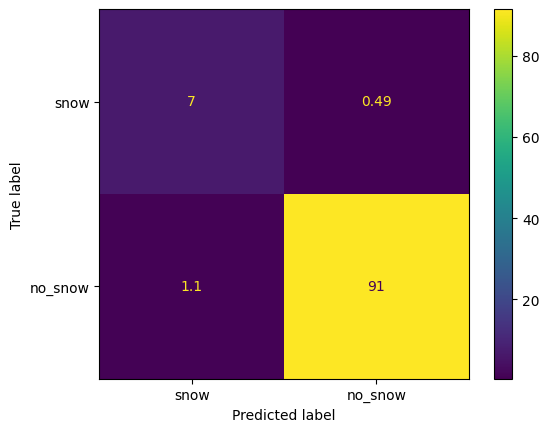

In [3]:
print("NASA L3 ")
print("Overall accuracy:", accuracy(nasa_l3_metrics_ds).values)
print("Forest accuracy:", accuracy(nasa_l3_metrics_ds.sel(forest_mask_bins=1)).values)
print("No forest accuracy:", accuracy(nasa_l3_metrics_ds.sel(forest_mask_bins=0)).values)
print("No snow accuracy:", accuracy(nasa_l3_metrics_ds.sel(ref_bins=0)).values)
print("Snow accuracy:", accuracy(nasa_l3_metrics_ds.isel(ref_bins=slice(1,None))).values)
plot_confusion_table(nasa_l3_metrics_ds.sel(ref_bins=nasa_l3_metrics_ds.ref_bins)) 

NASA pseudo L3
Overall accuracy: 0.9773047520711794
Forest accuracy: 0.9766423345363174
No forest accuracy: 0.9781839585713634
No snow accuracy: 0.9901327751417393
Snow accuracy: 0.9469583508707742


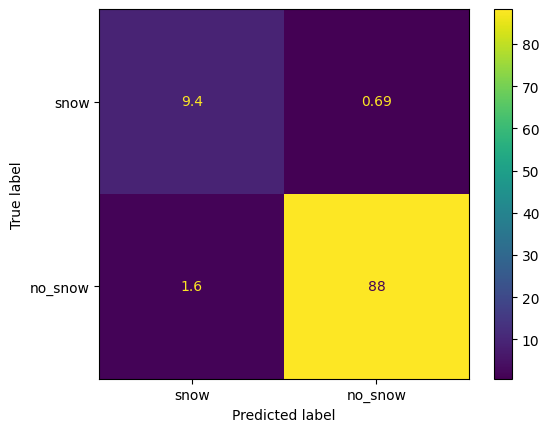

In [19]:
print("NASA pseudo L3")
print("Overall accuracy:", accuracy(nasa_pseudo_l3_metrics_ds).values)
print("Forest accuracy:", accuracy(nasa_pseudo_l3_metrics_ds.sel(forest_mask_bins=1)).values)
print("No forest accuracy:", accuracy(nasa_pseudo_l3_metrics_ds.sel(forest_mask_bins=0)).values)
print("No snow accuracy:", accuracy(nasa_pseudo_l3_metrics_ds.sel(ref_bins=0)).values)
print("Snow accuracy:", accuracy(nasa_pseudo_l3_metrics_ds.isel(ref_bins=slice(3,None))).values)
plot_confusion_table(nasa_pseudo_l3_metrics_ds.sel(ref_bins=nasa_l3_metrics_ds.ref_bins)) 

Météo-FranceL3 
Overall accuracy: 0.9637332105808276
Forest accuracy: 0.9586552571240358
No forest accuracy: 0.9711851136921418
No snow accuracy: 0.9777784404895905
Snow accuracy: 0.9539802269177751


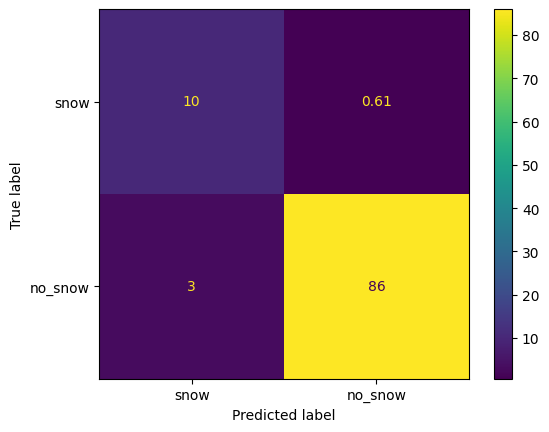

In [18]:
print("Météo-FranceL3 ")
print("Overall accuracy:", accuracy(mf_metrics_ds).values)
print("Forest accuracy:", accuracy(mf_metrics_ds.sel(forest_mask_bins=1)).values)
print("No forest accuracy:", accuracy(mf_metrics_ds.sel(forest_mask_bins=0)).values)
print("No snow accuracy:", accuracy(mf_metrics_ds.sel(ref_bins=0)).values)
print("Snow accuracy:", accuracy(mf_metrics_ds.isel(ref_bins=slice(3,None))).values)
plot_confusion_table(mf_metrics_ds.sel(ref_bins=mf_metrics_ds.ref_bins)) 

NASA L3 snow covered 


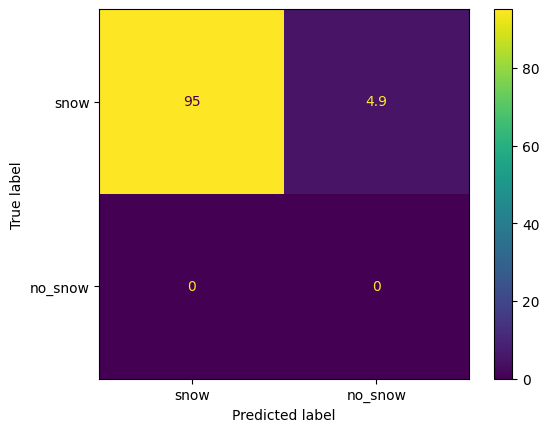

In [17]:
print("NASA L3 snow covered ")
plot_confusion_table(nasa_l3_metrics_ds.sel(ref_bins=nasa_l3_metrics_ds.ref_bins[3:])) 

Météo-France L3 snow covered 


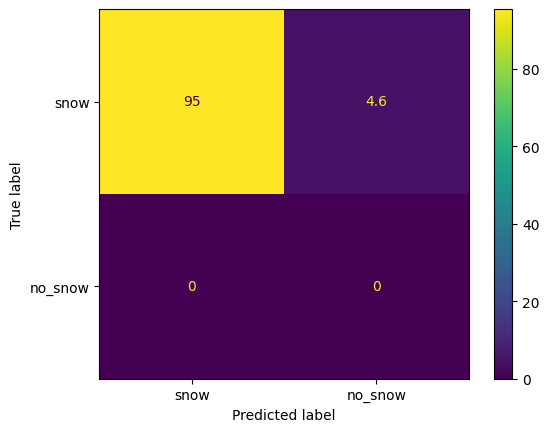

In [16]:
print("Météo-France L3 snow covered ")
plot_confusion_table(mf_metrics_ds.sel(ref_bins=mf_metrics_ds.ref_bins[3:])) 

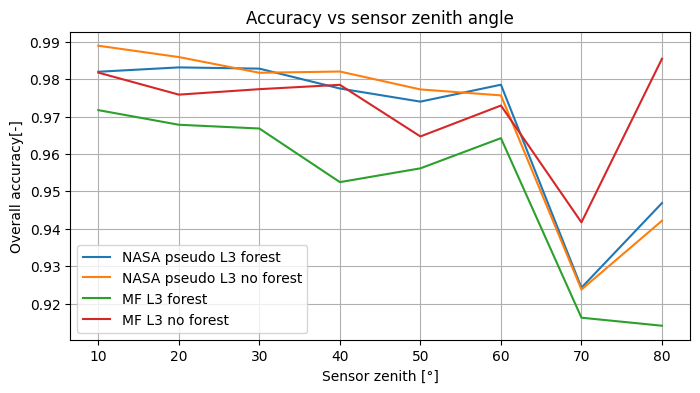

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,4))
solar_zenith_bins = nasa_pseudo_l3_metrics_ds.coords['sensor_zenith_bins'].values
ax.plot(solar_zenith_bins, nasa_pseudo_l3_metrics_ds.sel(forest_mask_bins=1).groupby('sensor_zenith_bins').map(accuracy), label='NASA pseudo L3 forest')
ax.plot(solar_zenith_bins, nasa_pseudo_l3_metrics_ds.sel(forest_mask_bins=0).groupby('sensor_zenith_bins').map(accuracy), label='NASA pseudo L3 no forest')
ax.plot(solar_zenith_bins, mf_metrics_ds.sel(forest_mask_bins=1).groupby('sensor_zenith_bins').map(accuracy), label='MF L3 forest')
ax.plot(solar_zenith_bins, mf_metrics_ds.sel(forest_mask_bins=0).groupby('sensor_zenith_bins').map(accuracy), label='MF L3 no forest')
ax.set_title('Accuracy vs sensor zenith angle')
ax.set_xlabel('Sensor zenith [°]')
ax.set_ylabel('Overall accuracy[-]')
ax.grid(True)
ax.legend()

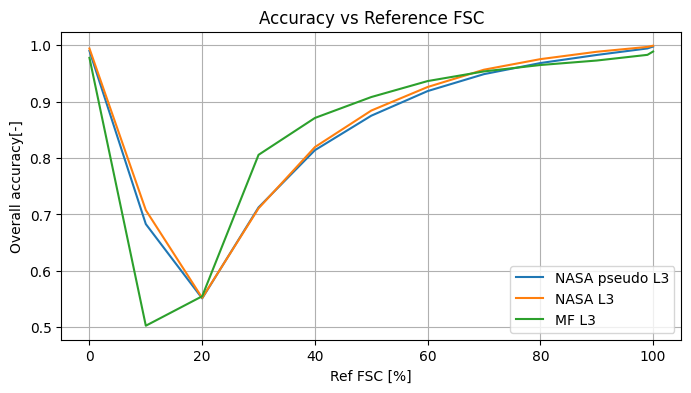

In [20]:
fig, ax = plt.subplots(figsize=(8,4))
ref_fsc_bins = nasa_pseudo_l3_metrics_ds.coords['ref_bins'].values
ax.plot(ref_fsc_bins, nasa_pseudo_l3_metrics_ds.groupby('ref_bins').map(accuracy), label='NASA pseudo L3')
ax.plot(ref_fsc_bins, nasa_l3_metrics_ds.groupby('ref_bins').map(accuracy), label='NASA L3')
ax.plot(ref_fsc_bins, mf_metrics_ds.groupby('ref_bins').map(accuracy), label='MF L3')
ax.set_title('Accuracy vs Reference FSC')
ax.set_xlabel('Ref FSC [%]')
ax.set_ylabel('Overall accuracy[-]')
ax.grid(True)
ax.legend()

In [9]:
2200*2800 / (10*2*7*3*8*8)

229.16666666666666

In [4]:
200*10*2*7*3*8*8

5376000

In [11]:
0.018*30*3*8*8

103.67999999999998